In [161]:
# Lead Scoring Case study
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('Leads.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [7]:
df.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

## Step 0. EDA and preprocessing of the data

In [6]:
import sweetviz as sv

my_report = sv.analyze(df)
my_report.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### We identified the features that are not useful to analysis-based on EDA. 
### Reason - most of these features are highly skewed, that there isn't any meaningful information (variance) in them. 


In [72]:
df_0 = df.drop(['Prospect ID','Lead Number','I agree to pay the amount through cheque',
         'Receive More Updates About Our Courses',
         'Update me on Supply Chain Content','Get updates on DM Content',
         'Newspaper Article', 'X Education Forums', 'Newspaper',
         'Digital Advertisement', 'Through Recommendations',
         'Do Not Call','Search', 'Magazine','What matters most to you in choosing a course'
        ], axis = 1)

In [73]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9204 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9137 non-null   object 
 8   Country                                 6779 non-null   object 
 9   Specialization                          7802 non-null   object 
 10  How did you hear about X Education      7033 non-null   obje

### We are left with 16 categorical features and 5 numerical features, and 1 target variable i.e. `Converted`

In [74]:
100 * df_0.isnull().sum() / len(df_0)

Lead Origin                                0.000000
Lead Source                                0.389610
Do Not Email                               0.000000
Converted                                  0.000000
TotalVisits                                1.482684
Total Time Spent on Website                0.000000
Page Views Per Visit                       1.482684
Last Activity                              1.114719
Country                                   26.634199
Specialization                            15.562771
How did you hear about X Education        23.885281
What is your current occupation           29.112554
Tags                                      36.287879
Lead Quality                              51.590909
Lead Profile                              29.318182
City                                      15.367965
Asymmetrique Activity Index               45.649351
Asymmetrique Profile Index                45.649351
Asymmetrique Activity Score               45.649351
Asymmetrique

In [19]:
my_report = sv.compare_intra(df_0, df_0['Converted'] == 1 ,['0','1'])
my_report.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### There is to much missing data (>35%) in some of the variables, we will drop those variables.

In [75]:
# getting columns names
cond = (100 * df_0.isnull().sum() / len(df_0) > 35)
missing_cols = df_0.columns.to_numpy()[cond]

In [76]:
df_0.drop(missing_cols, axis = 1, inplace = True)
df_0.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,Lead Profile,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Select,Select,No,Modified
1,API,Organic Search,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Select,Select,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Potential Lead,Mumbai,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Select,Mumbai,No,Modified
4,Landing Page Submission,Google,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Select,Mumbai,No,Modified


In [46]:
100 * df_0.isnull().sum() / len(df_0)

Lead Origin                                0.000000
Lead Source                                0.389610
Do Not Email                               0.000000
Converted                                  0.000000
TotalVisits                                1.482684
Total Time Spent on Website                0.000000
Page Views Per Visit                       1.482684
Last Activity                              1.114719
Country                                   26.634199
Specialization                            15.562771
How did you hear about X Education        23.885281
What is your current occupation           29.112554
Lead Profile                              29.318182
City                                      15.367965
A free copy of Mastering The Interview     0.000000
Last Notable Activity                      0.000000
dtype: float64

### `Country` and `City` are not useful to analyse whether a customer is hot lead or not, since, the course is online. So, dropping them as well.

In [77]:
df_0.drop(['Country','City'], axis = 1, inplace = True)

In [78]:
for col in df_0.columns:
    print(df_0[col].value_counts())
    print('='*50)

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Social Media            2
Press_Release           2
Live Chat               2
blog                    1
NC_EDM                  1
testone                 1
Pay per Click Ads       1
youtubechannel          1
WeLearn                 1
welearnblog_Home        1
Name: Lead Source, dtype: int64
No     8506
Yes     734
Name: Do Not Email, dtype: int64
0    5679
1    3561
Name: Converted, dtype: int64
0.0      2189
2.0      1680
3.0      1306
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       2

### Few variables have select as a category_level present in them, we delete these variables.

In [79]:
df_0.drop(['Lead Profile','How did you hear about X Education'], axis = 1, inplace = True)

In [80]:
100 * df_0.isnull().sum() / len(df_0)

Lead Origin                                0.000000
Lead Source                                0.389610
Do Not Email                               0.000000
Converted                                  0.000000
TotalVisits                                1.482684
Total Time Spent on Website                0.000000
Page Views Per Visit                       1.482684
Last Activity                              1.114719
Specialization                            15.562771
What is your current occupation           29.112554
A free copy of Mastering The Interview     0.000000
Last Notable Activity                      0.000000
dtype: float64

### We will now remove rows of data, that have null value for some remaining variables, as we cannot drop the entire columns.

In [81]:
df_0 = df_0.dropna()
df_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6373 entries, 0 to 9239
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             6373 non-null   object 
 1   Lead Source                             6373 non-null   object 
 2   Do Not Email                            6373 non-null   object 
 3   Converted                               6373 non-null   int64  
 4   TotalVisits                             6373 non-null   float64
 5   Total Time Spent on Website             6373 non-null   int64  
 6   Page Views Per Visit                    6373 non-null   float64
 7   Last Activity                           6373 non-null   object 
 8   Specialization                          6373 non-null   object 
 9   What is your current occupation         6373 non-null   object 
 10  A free copy of Mastering The Interview  6373 non-null   obje

In [82]:
print(df_0.shape, df.shape)

(6373, 12) (9240, 37)


### Final dataframe has 6373 out of 9240 datapoints.

##  Step 1. Converting categorical variables into dummy_variables.

In [83]:
cat_cols = df_0.columns[ df_0.dtypes == object ]
cat_cols

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [84]:
df_cate = pd.get_dummies(df_0[cat_cols], prefix = cat_cols, drop_first = True)
df_cate

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,...,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9234,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9235,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9236,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9237,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [85]:
df_0 = pd.concat([df_0, df_cate], axis = 1)
df_0.drop(cat_cols, axis = 1, inplace = True)
df_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6373 entries, 0 to 9239
Data columns (total 75 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Converted                                             6373 non-null   int64  
 1   TotalVisits                                           6373 non-null   float64
 2   Total Time Spent on Website                           6373 non-null   int64  
 3   Page Views Per Visit                                  6373 non-null   float64
 4   Lead Origin_Landing Page Submission                   6373 non-null   uint8  
 5   Lead Origin_Lead Add Form                             6373 non-null   uint8  
 6   Lead Origin_Lead Import                               6373 non-null   uint8  
 7   Lead Source_Direct Traffic                            6373 non-null   uint8  
 8   Lead Source_Facebook                                  6373

In [86]:
df_0.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,...,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0.0,0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,5.0,674,2.5,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,2.0,1532,2.0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1.0,305,1.0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,2.0,1428,1.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## Step 2. Splitting data into train and test data

In [ ]:
y = df_0.pop('Converted')
X = df_0

In [175]:
# splitting in 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

print(X_train.shape , X_test.shape)
print(y_train.shape, y_test.shape)

(4461, 74) (1912, 74)
(4461,) (1912,)


## Step 3. Scaling the numerical features via MinMaxScaler

In [176]:
scaler = MinMaxScaler()

X_train.iloc[:, :4] = scaler.fit_transform(X_train.iloc[:, :4])
X_test.iloc[:, :4] = scaler.transform(X_test.iloc[:, :4])

X_train[:5]

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,...,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
6243,0.008696,0.614877,0.018182,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7047,0.017391,0.505282,0.036364,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
8483,0.034783,0.736796,0.072727,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4125,0.095652,0.662412,0.066727,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4947,0.034783,0.353873,0.024182,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Step 4. Model Building

In [99]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

print('Train score:',clf.score(X_train, y_train))
print('Test score:',clf.score(X_test, y_test))



Train score: 0.7995965030262273
Test score: 0.799163179916318


In [100]:
 # running RFE with 15 variables as output
rfe = RFE(clf, n_features_to_select=15)            
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 6),
 ('Lead Origin_Landing Page Submission', False, 2),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 35),
 ('Lead Source_Direct Traffic', False, 17),
 ('Lead Source_Facebook', False, 34),
 ('Lead Source_Google', False, 19),
 ('Lead Source_Live Chat', False, 42),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 18),
 ('Lead Source_Pay per Click Ads', False, 59),
 ('Lead Source_Press_Release', False, 50),
 ('Lead Source_Reference', False, 5),
 ('Lead Source_Referral Sites', False, 20),
 ('Lead Source_Social Media', False, 9),
 ('Lead Source_WeLearn', False, 33),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 48),
 ('Lead Source_testone', False, 32),
 ('Do Not Email_Yes', True, 1),
 ('Last Activity_Converted to Lead', False, 7),
 ('Last Activity_Email Bounced', False, 10),
 ('Last Activity_Email Link Cl

In [103]:
rfe_col = X_train.columns[ rfe.support_ ] 
rfe_col

Index(['TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Do Not Email_Yes',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Unreachable'],
      dtype='object')

### This are the 15 useful features, output of RFE. Now, we will make a statsmodel classifier based on them

In [120]:
X_train_sm = X_train[ rfe_col ]

logreg = sm.GLM(y_train, sm.add_constant(X_train_sm),family = sm.families.Binomial())
result = logreg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4461
Model:                            GLM   Df Residuals:                     4445
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2078.1
Date:                Thu, 11 Nov 2021   Deviance:                       4156.2
Time:                        15:33:10   Pearson chi2:                 4.62e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.7925      0.675     -1.174      0.240      -2.116       0.531
TotalVisits                                              3.8416      1.125      3.415      0.001       1.637       6.046
Total Time Spent on Website                              4.5575      0.187     24.434      0.000       4.192       4.923
Lead Origin_Lead Add Form                                3.7732      0.232     16.235      0.000       3.318       4.229
Lead Source_Olark Chat                                   1.5566      0.126     12.399      0.000       1.311       1.803
Lead Source_Welingak Website                             1.7316      0.752      2.303      0.021       0.258       3.205
Do Not Email_Yes                                        -1.3128      0.186     -7.063      0.000      -1.677      -0.948
Last Activity_Had a Phone Conversation                   1.4029      1.267      1.107      0.268      -1.080       3.886
Last Activity_Olark Chat Conversation                   -1.1405      0.184     -6.212      0.000      -1.500      -0.781
Last Activity_SMS Sent                                   1.1010      0.083     13.256      0.000       0.938       1.264
What is your current occupation_Housewife               22.4677   2.46e+04      0.001      0.999   -4.82e+04    4.82e+04
What is your current occupation_Student                 -1.2287      0.703     -1.749      0.080      -2.606       0.148
What is your current occupation_Unemployed              -1.4409      0.672     -2.146      0.032      -2.757      -0.125
What is your current occupation_Working Professional     1.0204      0.694      1.470      0.142      -0.340       2.381
Last Notable Activity_Had a Phone Conversation          22.5212    1.9e+04      0.001      0.999   -3.71e+04    3.72e+04
Last Notable Activity_Unreachable                        2.3949      0.852      2.811      0.005       0.725       4.065
========================================================================================================================
"""

### Some of the features has p-value > 0.05, so, these features have insignificant p-values. Let's also check VIF

In [121]:
# Make a VIF dataframe for all the variables present

vif = pd.DataFrame()
x = X_train_sm
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,What is your current occupation_Unemployed,4.24
6,Last Activity_Had a Phone Conversation,3.21
13,Last Notable Activity_Had a Phone Conversation,3.20
1,Total Time Spent on Website,2.42
0,TotalVisits,2.17
2,Lead Origin_Lead Add Form,1.70
8,Last Activity_SMS Sent,1.65
12,What is your current occupation_Working Profes...,1.63
3,Lead Source_Olark Chat,1.60
4,Lead Source_Welingak Website,1.30


### VIF are below 5 but dropping variables with insignificant p-values

In [122]:
X_train_sm = X_train_sm.drop('What is your current occupation_Housewife', axis = 1)

logreg = sm.GLM(y_train, sm.add_constant(X_train_sm) ,family = sm.families.Binomial())
result = logreg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4461
Model:                            GLM   Df Residuals:                     4446
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2080.0
Date:                Thu, 11 Nov 2021   Deviance:                       4160.0
Time:                        15:34:18   Pearson chi2:                 4.63e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.1933      0.611     -0.316      0.752      -1.392       1.005
TotalVisits                                              3.7834      1.122      3.371      0.001       1.584       5.983
Total Time Spent on Website                              4.5570      0.186     24.438      0.000       4.191       4.922
Lead Origin_Lead Add Form                                3.7727      0.232     16.241      0.000       3.317       4.228
Lead Source_Olark Chat                                   1.5522      0.125     12.369      0.000       1.306       1.798
Lead Source_Welingak Website                             1.7294      0.752      2.300      0.021       0.256       3.203
Do Not Email_Yes                                        -1.3122      0.186     -7.061      0.000      -1.676      -0.948
Last Activity_Had a Phone Conversation                   1.4028      1.267      1.107      0.268      -1.080       3.886
Last Activity_Olark Chat Conversation                   -1.1443      0.184     -6.227      0.000      -1.504      -0.784
Last Activity_SMS Sent                                   1.1004      0.083     13.250      0.000       0.938       1.263
What is your current occupation_Student                 -1.8244      0.643     -2.837      0.005      -3.085      -0.564
What is your current occupation_Unemployed              -2.0369      0.609     -3.345      0.001      -3.230      -0.843
What is your current occupation_Working Professional     0.4240      0.634      0.669      0.503      -0.818       1.666
Last Notable Activity_Had a Phone Conversation          21.5216   1.15e+04      0.002      0.999   -2.25e+04    2.26e+04
Last Notable Activity_Unreachable                        2.3943      0.852      2.811      0.005       0.725       4.064
========================================================================================================================
"""

In [123]:
vif = pd.DataFrame()
x = X_train_sm
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,What is your current occupation_Unemployed,4.22
6,Last Activity_Had a Phone Conversation,3.21
12,Last Notable Activity_Had a Phone Conversation,3.20
1,Total Time Spent on Website,2.41
0,TotalVisits,2.17
2,Lead Origin_Lead Add Form,1.69
8,Last Activity_SMS Sent,1.65
11,What is your current occupation_Working Profes...,1.63
3,Lead Source_Olark Chat,1.60
4,Lead Source_Welingak Website,1.30


### dropping variable with most insignificant p-value

In [124]:
X_train_sm = X_train_sm.drop('Last Notable Activity_Had a Phone Conversation', axis = 1)

logreg = sm.GLM(y_train, sm.add_constant(X_train_sm) ,family = sm.families.Binomial())
result = logreg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4461
Model:                            GLM   Df Residuals:                     4447
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2081.7
Date:                Thu, 11 Nov 2021   Deviance:                       4163.4
Time:                        15:35:53   Pearson chi2:                 4.64e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.1928      0.611     -0.315      0.752      -1.391       1.005
TotalVisits                                              3.7930      1.123      3.378      0.001       1.592       5.994
Total Time Spent on Website                              4.5534      0.186     24.431      0.000       4.188       4.919
Lead Origin_Lead Add Form                                3.7699      0.232     16.227      0.000       3.315       4.225
Lead Source_Olark Chat                                   1.5514      0.125     12.364      0.000       1.306       1.797
Lead Source_Welingak Website                             1.7313      0.752      2.302      0.021       0.258       3.205
Do Not Email_Yes                                        -1.3122      0.186     -7.063      0.000      -1.676      -0.948
Last Activity_Had a Phone Conversation                   3.3082      1.082      3.058      0.002       1.188       5.429
Last Activity_Olark Chat Conversation                   -1.1442      0.184     -6.227      0.000      -1.504      -0.784
Last Activity_SMS Sent                                   1.1003      0.083     13.251      0.000       0.938       1.263
What is your current occupation_Student                 -1.8239      0.643     -2.837      0.005      -3.084      -0.564
What is your current occupation_Unemployed              -2.0365      0.609     -3.345      0.001      -3.230      -0.843
What is your current occupation_Working Professional     0.4235      0.633      0.669      0.504      -0.818       1.665
Last Notable Activity_Unreachable                        2.3935      0.852      2.810      0.005       0.724       4.063
========================================================================================================================
"""

In [125]:
vif = pd.DataFrame()
x = X_train_sm
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,What is your current occupation_Unemployed,4.22
1,Total Time Spent on Website,2.41
0,TotalVisits,2.17
2,Lead Origin_Lead Add Form,1.69
8,Last Activity_SMS Sent,1.65
11,What is your current occupation_Working Profes...,1.63
3,Lead Source_Olark Chat,1.60
4,Lead Source_Welingak Website,1.30
7,Last Activity_Olark Chat Conversation,1.23
9,What is your current occupation_Student,1.12


### Now, only variable has insignificant p-value

In [126]:
X_train_sm = X_train_sm.drop('What is your current occupation_Working Professional', axis = 1)

logreg = sm.GLM(y_train, sm.add_constant(X_train_sm) ,family = sm.families.Binomial())
result = logreg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4461
Model:                            GLM   Df Residuals:                     4448
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2081.9
Date:                Thu, 11 Nov 2021   Deviance:                       4163.8
Time:                        15:37:50   Pearson chi2:                 4.64e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.1991      0.187      1.064      0.287      -0.168       0.566
TotalVisits                                    3.7751      1.122      3.364      0.001       1.576       5.974
Total Time Spent on Website                    4.5545      0.186     24.436      0.000       4.189       4.920
Lead Origin_Lead Add Form                      3.7705      0.232     16.231      0.000       3.315       4.226
Lead Source_Olark Chat                         1.5508      0.125     12.361      0.000       1.305       1.797
Lead Source_Welingak Website                   1.7302      0.752      2.301      0.021       0.256       3.204
Do Not Email_Yes                              -1.3107      0.186     -7.058      0.000      -1.675      -0.947
Last Activity_Had a Phone Conversation         3.3099      1.082      3.059      0.002       1.189       5.430
Last Activity_Olark Chat Conversation         -1.1443      0.184     -6.227      0.000      -1.504      -0.784
Last Activity_SMS Sent                         1.1021      0.083     13.284      0.000       0.939       1.265
What is your current occupation_Student       -2.2157      0.274     -8.091      0.000      -2.752      -1.679
What is your current occupation_Unemployed    -2.4287      0.178    -13.669      0.000      -2.777      -2.080
Last Notable Activity_Unreachable              2.3945      0.852      2.811      0.005       0.725       4.064
==============================================================================================================
"""

In [127]:
vif = pd.DataFrame()
x = X_train_sm
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,What is your current occupation_Unemployed,3.13
1,Total Time Spent on Website,2.07
0,TotalVisits,2.01
8,Last Activity_SMS Sent,1.55
3,Lead Source_Olark Chat,1.48
2,Lead Origin_Lead Add Form,1.43
4,Lead Source_Welingak Website,1.28
7,Last Activity_Olark Chat Conversation,1.23
5,Do Not Email_Yes,1.09
9,What is your current occupation_Student,1.09


### Finally, our model has 12 features - with significant p-values and good VIF

## Step 5. Model Evaluation

In [130]:
result.predict(sm.add_constant(X_train_sm[:5]))

6243    0.995832
7047    0.534276
8483    0.913686
4125    0.904694
4947    0.954530
dtype: float64

### Taking 0.5 probability value as a threshold to classify class labels - `Converted`

In [142]:
thresh = 0.5
y_pred = [1 if x>thresh else 0 for x in result.predict(sm.add_constant(X_train_sm))]

cm = confusion_matrix(y_train, y_pred)
cm

array([[1901,  399],
       [ 548, 1613]], dtype=int64)

In [147]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

print(TP, FP, FN, TN, sep = '\n')

1613
399
548
1901


### To fine tune the threshold, we will have to make a decision based on performance metrics. We can use a number of performance metrics like - 
* accuracy-sensitivity-specificity,
* precision-recall, auc
* We must make this decision based on business requirements. 

### Another point we are considering is to select threshold that minimizes FN i.e. the customer that were converted but our model predicted them as not converted, so we might miss  potential customer.

In [148]:
# sensitivity

TP/ (TP+FN)

0.7464136973623322

In [151]:
# specificity
TN/ (TN+FP)


0.8265217391304348

### Checking the auc score of the plot

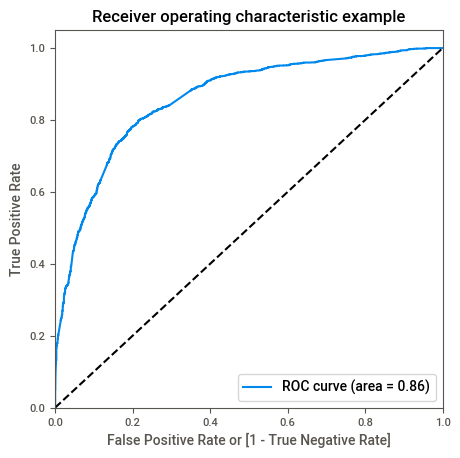

In [165]:
# ROC function from reference notebook
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

draw_roc(y_train, result.predict(sm.add_constant(X_train_sm)))

### Finding optimal threshold- by accuracy, sensitivity and specificity scores

In [153]:
thresholds = np.linspace(0,1,11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

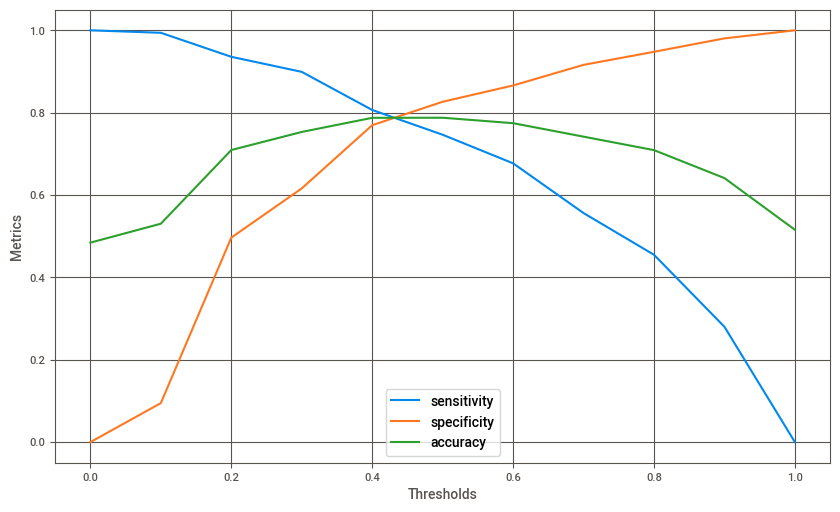

In [160]:
sensitivity, specificity, accuracy = [],[],[]
for i in thresholds:
    y_pred = [1 if x>i else 0 for x in result.predict(sm.add_constant(X_train_sm))]
    cm = confusion_matrix(y_train, y_pred)
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    sensitivity.append(TP/ (TP+FN) )
    specificity.append(TN/ (TN+FP))
    accuracy.append((TP+TN)/ (TP+TN+FP+FN))
 
plt.figure(figsize = (10,6))
sns.lineplot(thresholds, sensitivity, label = 'sensitivity')
sns.lineplot(thresholds, specificity, label = 'specificity')
sns.lineplot(thresholds, accuracy, label = 'accuracy')
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Metrics')
plt.grid()
plt.show()


### Best value of threshold that balances accuracy, specificity and sensitivity is around [0.43], from the above graph.

### Checking confusion matrix for thresholds = 0.43

In [166]:
thresh = 0.43
y_pred = list(map(lambda x : 1 if x>thresh else 0 , result.predict(sm.add_constant(X_train_sm))))
cm = confusion_matrix(y_train, y_pred)
cm

array([[1816,  484],
       [ 452, 1709]], dtype=int64)

### Interpretations-

1. Overall our FN improved from 548 to 452, we should have been able to further reduce FN, from business point of view. But, this are the limitations of the current model.

### Evaluations of Result on the test set

In [186]:
X_test_sm = X_test[ rfe_col ].drop(['What is your current occupation_Housewife', 
                                    'What is your current occupation_Working Professional',
                                    'Last Notable Activity_Had a Phone Conversation'], axis = 1)

y_test_prob = result.predict(sm.add_constant(X_test_sm))
y_test_pred = list(map(lambda x : 1 if x>thresh else 0 , y_test_prob))

In [188]:
roc_auc_score(y_test, y_test_prob)

0.8674497822727911

In [193]:
cm = confusion_matrix(y_test, y_test_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
cm

array([[795, 213],
       [193, 711]], dtype=int64)

In [194]:
# sensitivity 
TP / (TP + FN)

0.786504424778761

In [195]:
# specificity
TN / (TN + FP)

0.7886904761904762

In [196]:
# accuracy 
accuracy_score(y_test, y_test_pred)

0.7876569037656904

In [198]:
X_train_sm.columns

Index(['TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Do Not Email_Yes',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'Last Notable Activity_Unreachable'],
      dtype='object')

## Conclusions-

1. We selected threshold probability of 0.43 that optimizes - accuracy, sensitivity and specificity.
2. Got test accuracy = 0.78, test sensitivity = 0.78, test specificity = 0.78
3. The most useful 12 features that we found in through our analysis - <br>
`   'TotalVisits',
    'Total Time Spent on Website',
    'Lead Origin_Lead Add Form',
    'Lead Source_Olark Chat',
    'Lead Source_Welingak Website',
    'Do Not Email_Yes',
    'Last Activity_Had a Phone Conversation',
    'Last Activity_Olark Chat Conversation',
    'Last Activity_SMS Sent',
    'What is your current occupation_Student',
    'What is your current occupation_Unemployed',
    'Last Notable Activity_Unreachable' `


In [199]:
result.params

const                                         0.199051
TotalVisits                                   3.775059
Total Time Spent on Website                   4.554523
Lead Origin_Lead Add Form                     3.770466
Lead Source_Olark Chat                        1.550839
Lead Source_Welingak Website                  1.730156
Do Not Email_Yes                             -1.310651
Last Activity_Had a Phone Conversation        3.309877
Last Activity_Olark Chat Conversation        -1.144256
Last Activity_SMS Sent                        1.102089
What is your current occupation_Student      -2.215692
What is your current occupation_Unemployed   -2.428704
Last Notable Activity_Unreachable             2.394521
dtype: float64